### Import Statements

In [163]:
import os, nltk, string
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize

In [164]:
# setting seaborn as the default style
sns.set_theme()

### Constants

In [165]:
BASE_PATH = '../data'
NEWS_DATA_PATH = os.path.join(BASE_PATH , 'raw_analyst_ratings.csv')

### Load data

In [166]:
news_df = pd.read_csv(NEWS_DATA_PATH , index_col=False)

In [167]:
# remove the index column
news_df = news_df.drop(columns=['Unnamed: 0'])

### 1) Descriptive Statistics

* Look for missing values in every column

In [168]:
news_df.count() / news_df.shape[0]

headline     1.0
url          1.0
publisher    1.0
date         1.0
stock        1.0
dtype: float64

There are no missing values in any of the columns.

* Count the number of publishers

In [169]:
publisher_count = news_df['publisher'].nunique()

In [170]:
print(f'There are {publisher_count} unique publishers in the dataset')

There are 1034 unique publishers in the dataset


* Count the number of articles per publisher and arrange them in descending order based on the number of articles published. The print the top publishers.

In [171]:
publisher_grouping = news_df.groupby('publisher').count().sort_values(by='headline' , ascending=False)

Print the top 50 publishers , by amount of publishes

In [172]:
publisher_grouping.head(n=50)

,headline,url,date,stock
publisher,,,,
Paul Quintaro,228373,228373,228373,228373
Lisa Levin,186979,186979,186979,186979
Benzinga Newsdesk,150484,150484,150484,150484
Charles Gross,96732,96732,96732,96732
Monica Gerson,82380,82380,82380,82380
Eddie Staley,57254,57254,57254,57254
Hal Lindon,49047,49047,49047,49047
ETF Professor,28489,28489,28489,28489
Juan Lopez,28438,28438,28438,28438


* Length of headlines

Find the length of the headlines and add them to a new column called 'headline_len'. Use a lambda funciton to obtain the length of the headlines.

In [173]:
news_df["headline_len"] = news_df["headline"].apply( lambda x : len(x))

Basic statistics for the headline length and produce a box plot for showing outliers

In [174]:
news_df["headline_len"].describe()

count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_len, dtype: float64

5 number summary for the headline length:
* The shortest headline has **3** words/characters in it.
* The longest headline has **512** words/characters in it.
* On average a headline has **40.7** words/characters in it.
* The 25th percentile has **47** words/characters in it.
* The 75th percentile has **87** words/cahracters in it.

<Axes: ylabel='headline_len'>

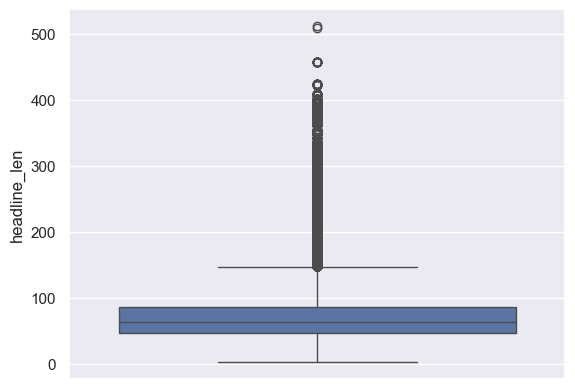

In [175]:
# let us drow a box plot
sns.boxplot(data=news_df["headline_len"])

We can see that the shape of our data is right-skewed

* Now let us analyze the publication dates , to indentify trends on when articles come out

In [176]:
# let us convert the date string to pd.DateTime object
news_df['date_conv'] = pd.to_datetime(news_df['date'] , utc=True , format="mixed")

In [177]:
# now let us breakdown the pd.DateTime object to hour , day and month
news_df['hour'] = news_df['date_conv'].dt.hour
news_df['day'] = news_df['date_conv'].dt.day_name()
news_df['month'] = news_df['date_conv'].dt.month_name()

Let us arrange the orders of the days and also the month, since it uses values of the results rather than the order of the days or the months

In [178]:
# Order of the months
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

# Order of the days
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Convert the 'month' column to a categorical type with a specific order
news_df['month'] = pd.Categorical(news_df['month'], categories=month_order, ordered=True)

# Convert the 'day' column to a categorical type with a specific order
news_df['day'] = pd.Categorical(news_df['day'], categories=day_order, ordered=True)


In [179]:
news_df['hour'].value_counts(normalize=True)

hour
0     0.960311
14    0.005449
13    0.004239
16    0.004073
15    0.004051
12    0.003927
11    0.003576
20    0.002799
21    0.001990
17    0.001926
10    0.001759
18    0.001474
9     0.001300
19    0.001145
8     0.001044
22    0.000500
23    0.000161
7     0.000066
1     0.000058
4     0.000048
6     0.000041
2     0.000034
3     0.000019
5     0.000010
Name: proportion, dtype: float64

<Axes: xlabel='hour', ylabel='proportion'>

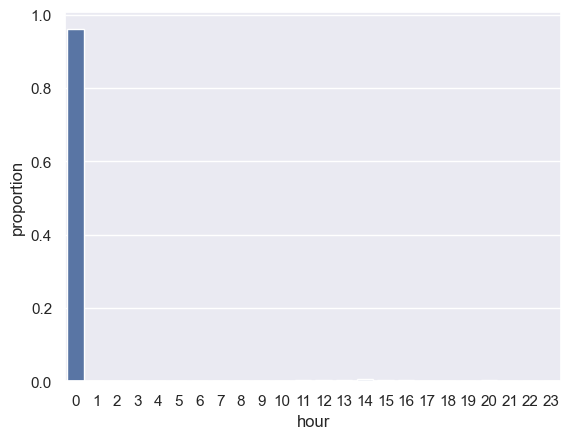

In [180]:
sns.barplot(news_df['hour'].value_counts(normalize=True))

As we can see from the plot and also the print of the hours in which the news articles are published: 
* 96.03% of the articles are published at hour 0 (12 AM) 

Now let us look at the days of the weeks where articles are published

In [181]:
news_df['day'].value_counts(normalize=True)

day
Thursday     0.215031
Wednesday    0.213825
Tuesday      0.210686
Monday       0.188399
Friday       0.154845
Sunday       0.011700
Saturday     0.005513
Name: proportion, dtype: float64

<Axes: xlabel='day', ylabel='proportion'>

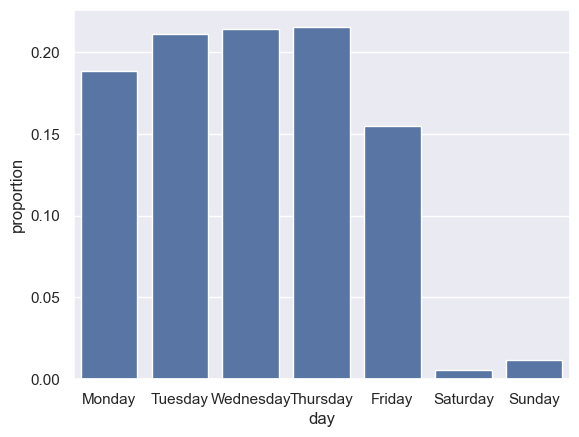

In [182]:
sns.barplot(news_df['day'].value_counts(normalize=True))

From the print and the plot we can conclude that:
* **Weekdays** have significantly higher rates of articles getting published , the lowest being **Friday** (where **15.48%** of articles are pubished)
* For **weekends** **1.17%** of articles are published on Sunday while **0.55%** of articles are published on **Saturday**
* **Thrusday** , **Wednesday** and **Tuesday** have around the same values with values each at **21%** 
* **18.8%** articles were published on **Monday**.

In [183]:
news_df['month'].value_counts(normalize=True)

month
May          0.092615
October      0.088679
August       0.088139
February     0.087283
March        0.086653
April        0.086556
January      0.086366
November     0.086284
July         0.078705
June         0.075745
December     0.074697
September    0.068278
Name: proportion, dtype: float64

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'January'),
  Text(1, 0, 'February'),
  Text(2, 0, 'March'),
  Text(3, 0, 'April'),
  Text(4, 0, 'May'),
  Text(5, 0, 'June'),
  Text(6, 0, 'July'),
  Text(7, 0, 'August'),
  Text(8, 0, 'September'),
  Text(9, 0, 'October'),
  Text(10, 0, 'November'),
  Text(11, 0, 'December')])

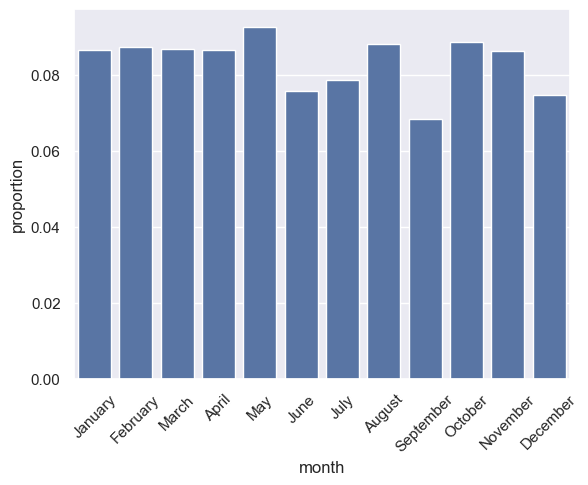

In [184]:
sns.barplot(news_df['month'].value_counts(normalize=True))
plt.xticks(rotation=45)

When looking at the publication distribution across months of the year we see an even ditribution amonth the months. There isn't any noticible spike or decline in publications 

### 2) Text Analysis

First let's download nltk resources for performing NLP and sentiment analysis. The resources are:
* vader_lexicon: A scored list of words and jargon that NLTK references when performing sentiment analysis
* punkt_tab: A data model created by Jan Strunk that NLTK uses to split full texts into word lists (Tokenizer)
* stopwords: A list of really common words, like articles, pronouns, prepositions, and conjunctions
* averaged_perceptron_tagger: A data model that NLTK uses to categorize words into their part of speech

In [185]:
# Downloading nltk resources for performing NLP and sentiment analysis
nltk.download([
    "vader_lexicon",
    "punkt_tab",
    "stopwords",
    "averaged_perceptron_tagger"
])

[nltk_data] Downloading package vader_lexicon to C:\Users\VICTUS
[nltk_data]     16\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\VICTUS
[nltk_data]     16\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\VICTUS
[nltk_data]     16\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\VICTUS 16\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

* Let us apply sentiment analysis to the headlines of the article and then we will see how many of them have a postive, neutral or negative sentiment

In [186]:
# let us initialize NLTK's pre-trained sentiment analyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

In [187]:
# apply the sentiment analyzer to obtain the sentiment and intensity of the sentiment
news_df['headline_sentiment'] = news_df['headline'].apply(lambda headline: sentiment_analyzer.polarity_scores(headline)["compound"])

* Now let us classify those sentiments as very-positive, positive, neutral, negative and very-negavtive.

The ranges I chose for the different classifications are as follows:
* **very-positive**: 0.7 - 1
* **positive**: 0.1 - 0.7
* **neutral**: -0.1 - 0.1
* **negative**: -0.7 - -0.1
* **very-negative**: -1 - -0.7

In [188]:
# now we can 
news_df['sentiment_category'] = pd.cut(x=news_df['headline_sentiment'] , bins=[-1, -0.7, -0.1, 0.1, 0.7, 1] , labels=["very-negative", "negative", "neutral", "positive", "very-positive"], precision=3)

Now let us count the distribution of sentiment across our entire dataset

In [189]:
news_df['sentiment_category'].value_counts(normalize=True)

sentiment_category
neutral          0.535337
positive         0.287103
negative         0.149529
very-positive    0.022335
very-negative    0.005697
Name: proportion, dtype: float64

<Axes: xlabel='sentiment_category', ylabel='proportion'>

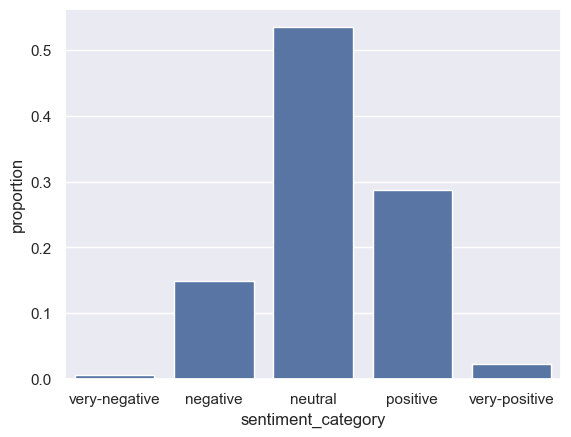

In [190]:
sns.barplot(news_df['sentiment_category'].value_counts(normalize=True))

So we can see that:
* **53.54%** of the dataset has a headline with a **neutral** sentiment
* **28.71%** of the dataset has a headline with positive sentiment
* **14.95%** of the dataset has a headline with **negative** sentiment
* **2.23%** of the dataset has a headline with a **very-positive** sentiment
* **0.57%** of the dataset has a headline with a **very-negative** sentiment

Now let us try to extract common words that are found in the headlines.

In [191]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [192]:
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)
def get_tokens(headline: str):
    '''
    A function that will return a list of token/strings obtained from a headline. It only return words that aren't stop words and aren't punctuations.

    Args:
        - headline(str): the headline data to be tokenized
    Returns:
        - List[str]: the list of tokens of the headline passed to the function 
    '''
    headline = headline.lower()
    tokens = word_tokenize(headline)
    result = [token.strip() for token in tokens if token.strip() not in stop_words and token.strip() not in punctuation]
    return result

In [193]:
words_df = pd.DataFrame()
words_df = news_df["headline"].apply(get_tokens)

In [194]:
# Flatten the list of tokenized words
all_words = [word for tokens in words_df for word in tokens]

In [195]:
# Count the frequency of each word
word_counts = Counter(all_words)

# Get the most common words
most_common_words = word_counts.most_common()

Let us print the top 50 words

In [196]:
most_common_words[:50]

[("'s", 206646),
 ('stocks', 161702),
 ('vs', 138835),
 ('eps', 128801),
 ('est', 122289),
 ('shares', 114140),
 ('reports', 108688),
 ('update', 91645),
 ('market', 91080),
 ('earnings', 87183),
 ('sales', 79528),
 ('top', 78493),
 ('benzinga', 74466),
 ('pt', 73059),
 ('announces', 66531),
 ('price', 64217),
 ('buy', 63928),
 ('downgrades', 61942),
 ('trading', 61146),
 ('raises', 57793),
 ('upgrades', 56802),
 ('target', 54669),
 ('maintains', 52960),
 ('52-week', 49802),
 ('higher', 48150),
 ('new', 47875),
 ('session', 45333),
 ('says', 43123),
 ('moving', 42248),
 ('q4', 40448),
 ('stock', 39334),
 ('inc.', 38720),
 ('q1', 38433),
 ('sees', 37971),
 ('estimate', 37938),
 ('q2', 37578),
 ('mid-day', 37276),
 ('q3', 36818),
 ('energy', 35604),
 ('initiates', 34981),
 ('us', 34970),
 ('companies', 34390),
 ('neutral', 34352),
 ('lower', 34184),
 ('bank', 34058),
 ('lowers', 33855),
 ('scheduled', 32835),
 ('coverage', 32323),
 ('company', 31012),
 ('morgan', 30970)]

We can see that from the words we can get the following financial terms:
* **q1**, **q2**, **q3** and **q4** which correspond to quarter one, two, three and four respectively. They are a 3 month period in which a company reports its financial results. 
* **shares**
* **earning**
* **eps** which stands for **Earning per share**
* **price**
* **stock**
* **estimate**

Terms that signify rise and fall of values:
* **higher**
* **lower**

### 3) Time Series Analysis

Let us prepaire the time series data by counting the publications per day of the week and prepairing a pandas dataframe from it

In [197]:
# count the daily headlines
daily_headlines = news_df.groupby('day').size()

# create a DataFrame
time_series_data = pd.DataFrame({'day' : daily_headlines.index , 'publications' : daily_headlines.values})

# print out the timeseries data
time_series_data

C:\Users\VICTUS 16\AppData\Local\Temp\ipykernel_14048\1115098465.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  daily_headlines = news_df.groupby('day').size()


,day,publications
0,Monday,265139
1,Tuesday,296505
2,Wednesday,300922
3,Thursday,302619
4,Friday,217918
5,Saturday,7759
6,Sunday,16466


Let us decompose the time_series data. We can choose between additive model and multiplicative model and also select the period. Let us try with additive model first then we will try it with multiplicative then finally we will select the better decomposition, while doing that we will set the period to 1

In [198]:
# a constant for holding the period
PERIOD = 1

additive_decomp = seasonal_decompose(time_series_data['publications'], model='additive', period=PERIOD)
multipicative_decomp = seasonal_decompose(time_series_data['publications'], model='multiplicative', period=PERIOD)

Now let us plot the decompositions

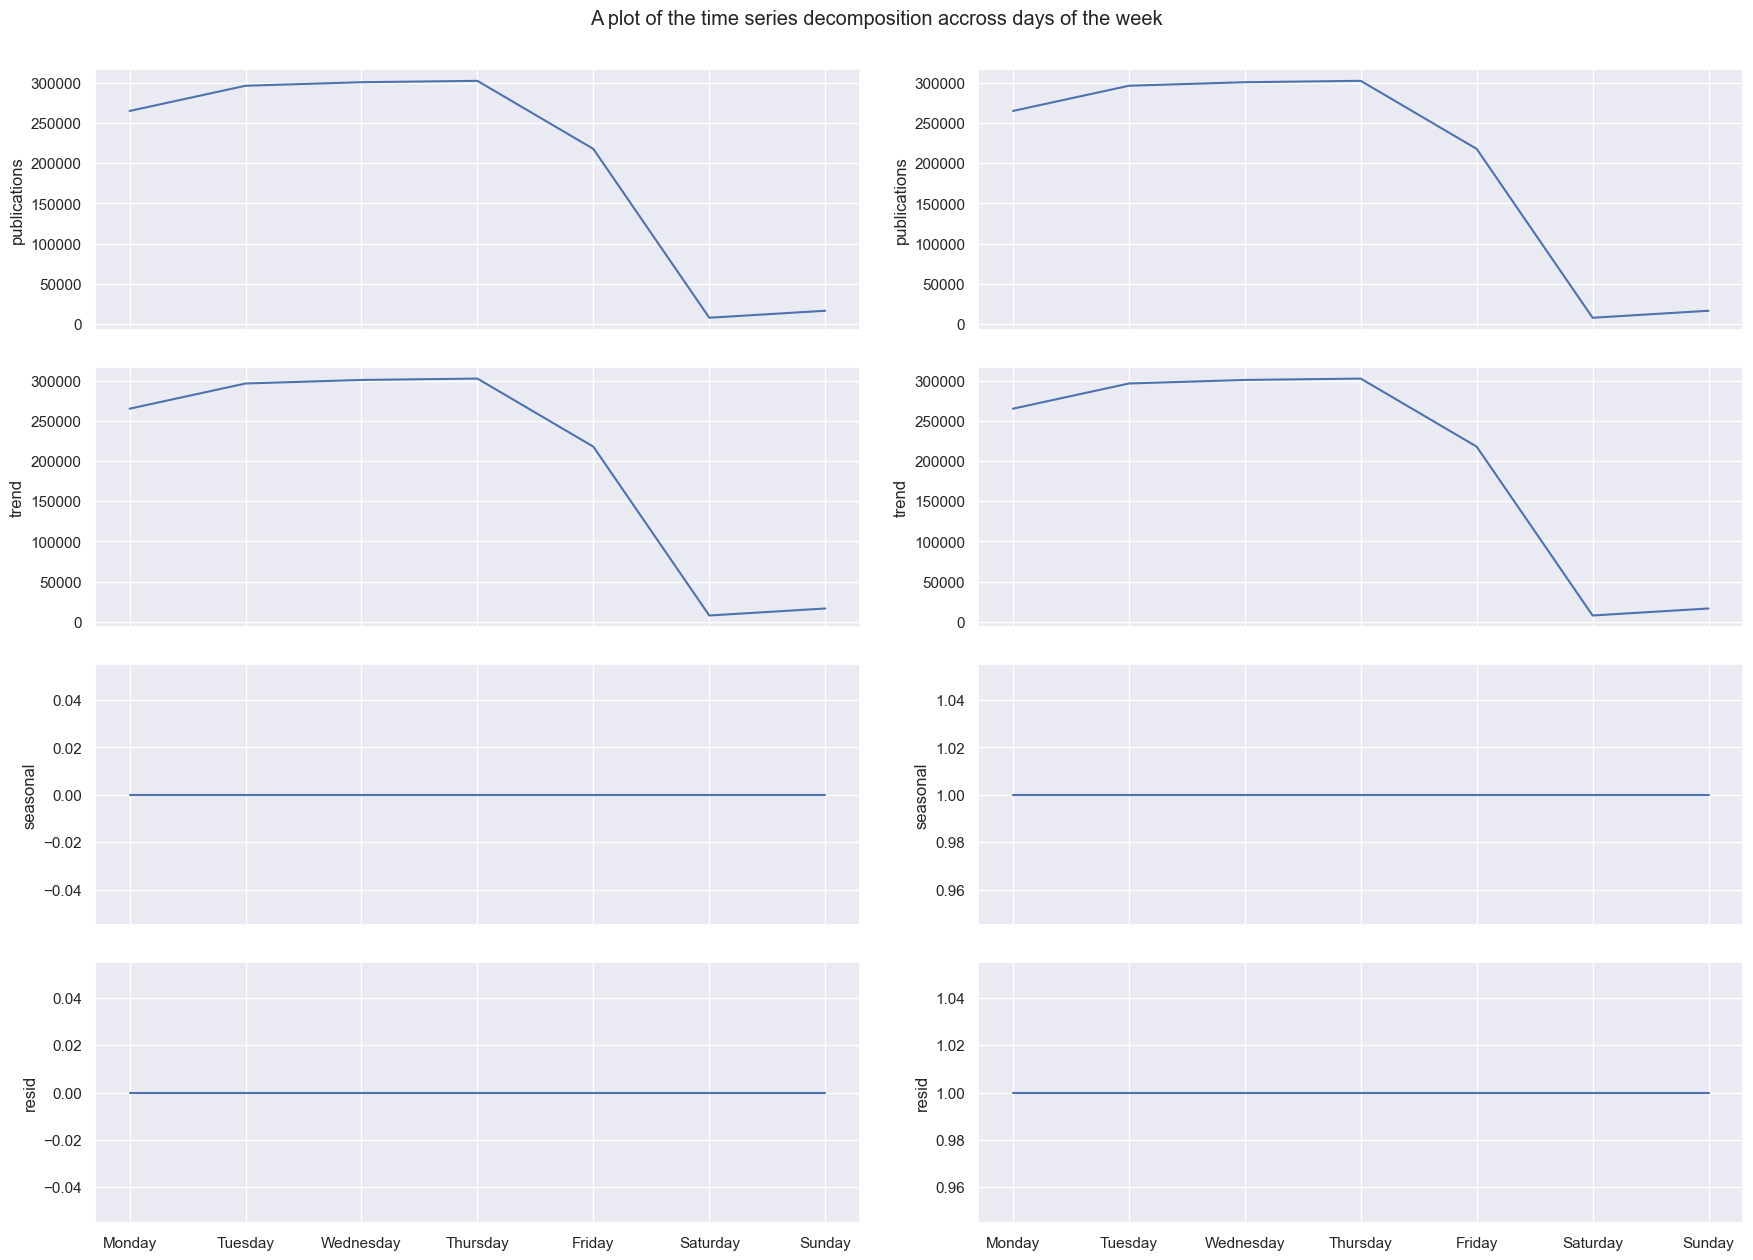

In [199]:
fig, ax = plt.subplots(ncols=2, nrows=4, figsize=(18,13), squeeze=True , sharex=True)

# set the title for the figure
fig.suptitle("A plot of the time series decomposition accross days of the week")

# plot the additive decomposition
sns.lineplot(data=time_series_data, x="day" , y="publications", ax=ax[0][0]) # this plots the original value
sns.lineplot(data=additive_decomp.trend , ax=ax[1][0]) # this plots the trend
sns.lineplot(data=additive_decomp.seasonal , ax=ax[2][0]) # this plots the seasonal paterns
sns.lineplot(data=additive_decomp.resid , ax=ax[3][0]) # this plots the residual paterns


# plot the multiplicative dcomposition
sns.lineplot(data=time_series_data, x="day" , y="publications", ax=ax[0][1]) # this plots the original value
sns.lineplot(data=multipicative_decomp.trend , ax=ax[1][1]) # this plots the trend
sns.lineplot(data=multipicative_decomp.seasonal , ax=ax[2][1]) # this plots the seasonal paterns
sns.lineplot(data=multipicative_decomp.resid , ax=ax[3][1]) # this plots the residual paterns

# Adjust spacing between subplots
plt.tight_layout(pad=2)

From the time series plot we can conclude that:
* We have a trend where publication will be constantly outputed for the week-days and then there will be a sharp down trend during the weekends
* There is no seasonality in our data, when broke down by days of the week
* Our resid is 0 , so it means that there are no inexplainable paterns the decompositions missed 

Now let us see the trend when we arrange our timeseries data over months of the year

In [200]:
# count the daily headlines
monthly_headlines = news_df.groupby('month').size()

# create a DataFrame
time_series_data = pd.DataFrame({'month' : monthly_headlines.index , 'publications' : monthly_headlines.values})

# print out the timeseries data
time_series_data

C:\Users\VICTUS 16\AppData\Local\Temp\ipykernel_14048\2916097437.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_headlines = news_df.groupby('month').size()


,month,publications
0,January,121545
1,February,122836
2,March,121949
3,April,121813
4,May,130340
5,June,106598
6,July,110764
7,August,124041
8,September,96089
9,October,124800


Let us decompose the time_series data. We can choose between additive model and multiplicative model and also select the period. Let us try with additive model first then we will try it with multiplicative then finally we will select the better decomposition, while doing that we will set the period to 1

In [201]:
# a constant for holding the period
PERIOD = 1

additive_decomp = seasonal_decompose(time_series_data['publications'], model='additive', period=PERIOD)
multipicative_decomp = seasonal_decompose(time_series_data['publications'], model='multiplicative', period=PERIOD)

Now let us plot the decompositions

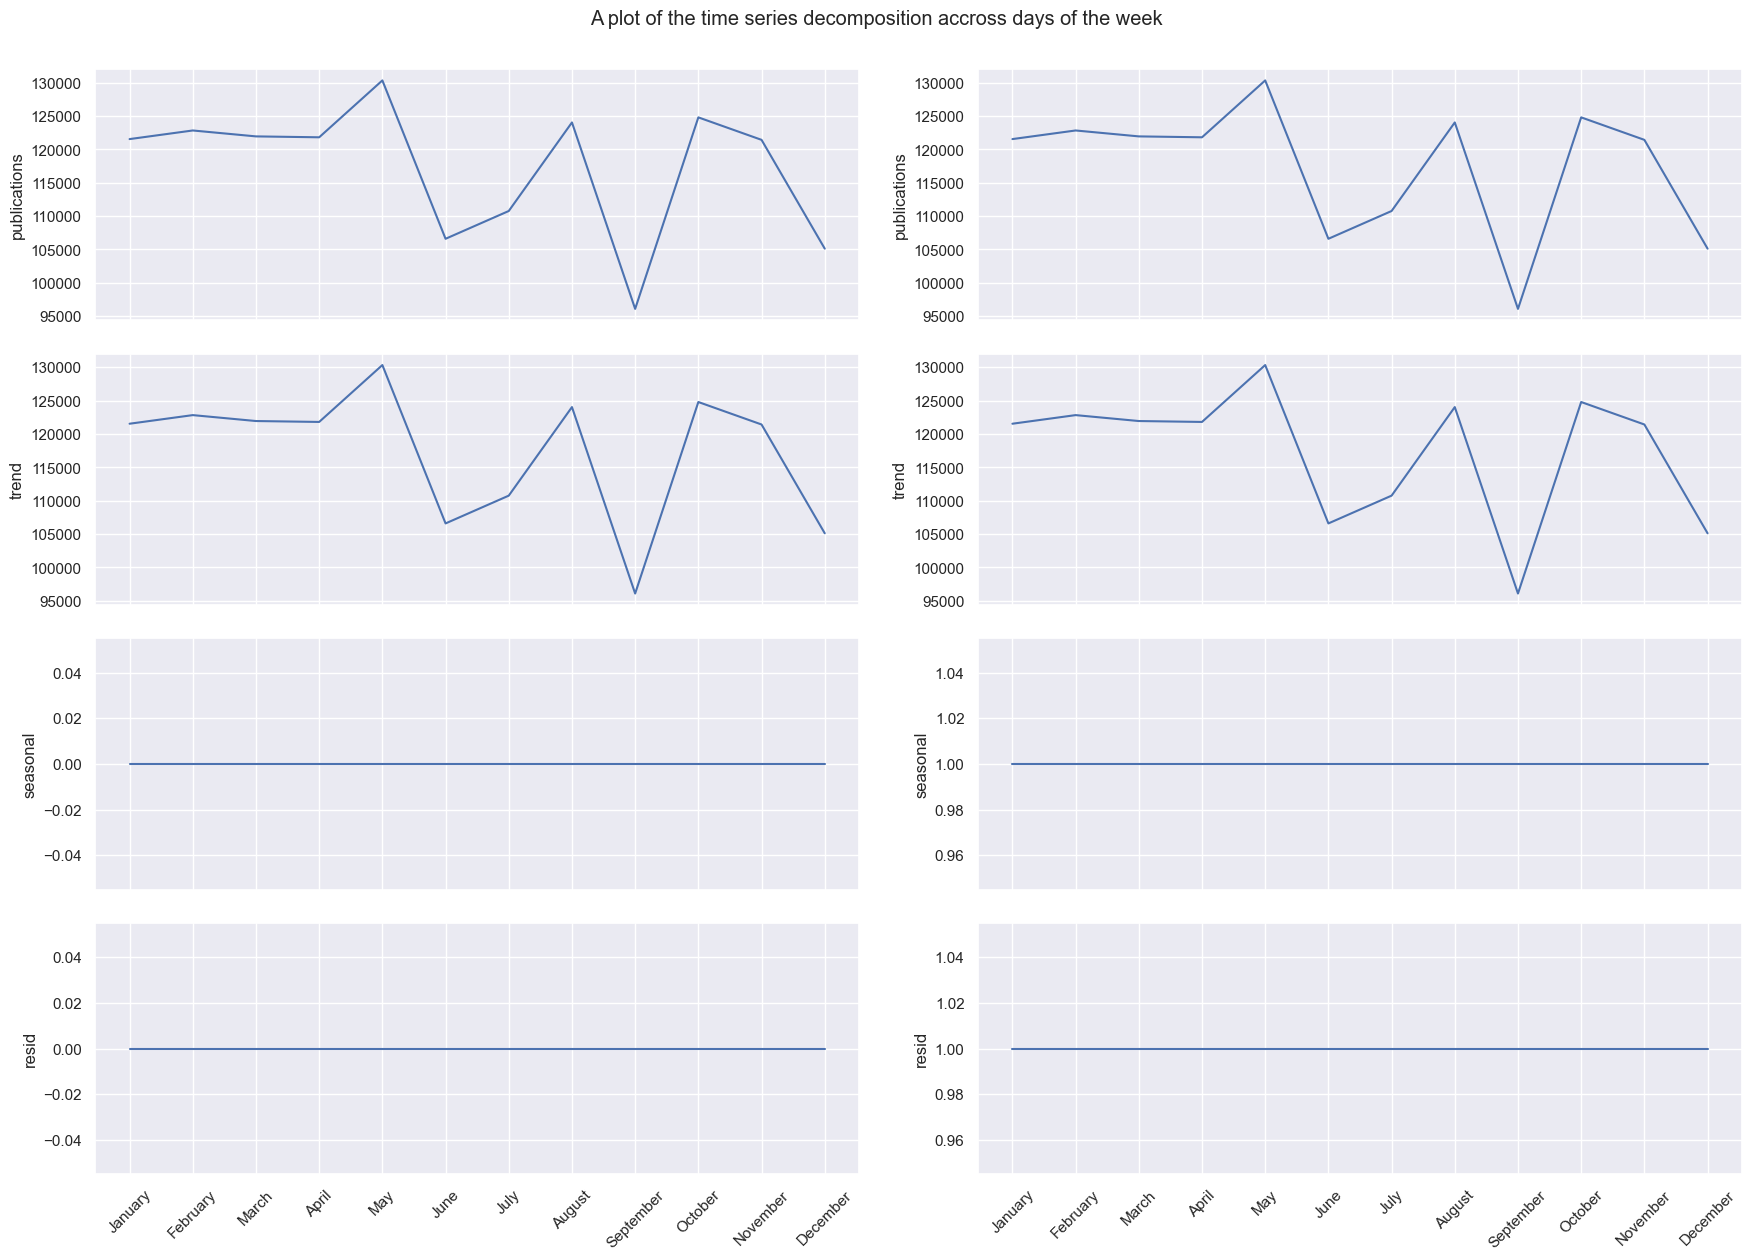

In [202]:
fig, ax = plt.subplots(ncols=2, nrows=4, figsize=(18,13), squeeze=True , sharex=True)

# set the title for the figure
fig.suptitle("A plot of the time series decomposition accross days of the week")

# plot the additive decomposition
sns.lineplot(data=time_series_data, x="month" , y="publications", ax=ax[0][0]) # this plots the original value
sns.lineplot(data=additive_decomp.trend , ax=ax[1][0]) # this plots the trend
sns.lineplot(data=additive_decomp.seasonal , ax=ax[2][0]) # this plots the seasonal paterns
sns.lineplot(data=additive_decomp.resid , ax=ax[3][0]) # this plots the residual paterns

plt.setp(ax[3][0].get_xticklabels(), rotation=45)

# plot the multiplicative dcomposition
sns.lineplot(data=time_series_data, x="month" , y="publications", ax=ax[0][1]) # this plots the original value
sns.lineplot(data=multipicative_decomp.trend , ax=ax[1][1]) # this plots the trend
sns.lineplot(data=multipicative_decomp.seasonal , ax=ax[2][1]) # this plots the seasonal paterns
sns.lineplot(data=multipicative_decomp.resid , ax=ax[3][1]) # this plots the residual paterns

plt.setp(ax[3][1].get_xticklabels(), rotation=45)

# Adjust spacing between subplots
plt.tight_layout(pad=2)

From the time series plot we can conclude that:
* There is no seasonality in our data, when broke down by months of the year
* Our residual is 0 , so it means that there are no inexplainable paterns the decompositions missed
* There is a constant trend of publication between **January** and **April** , there is a very strong downward trend from **August** to **September**  

### 4) Publisher Analysis

Let us look for publishers that have an email as their publisher name

In [203]:
news_df["publisher"].map(lambda publisher : "@" in publisher).value_counts()

publisher
False    1399240
True        8088
Name: count, dtype: int64

As we can see there are about 8088 publishers with an email as thier publisher name, now let us filter them

In [204]:
# select the publisher with an email domain by looking for the @ sign
email_publishers =  news_df[news_df["publisher"].str.contains("@")]

Now let us obtain the organization name from the email

In [205]:
def obtain_organization(email: str):
    '''
    A function that returns the organization/domain name of a given email.

    Args:
        - email(str): the email whose organization/domain we want to obtain
    
    Return:
        - string: the organization name
    '''

    # split on the @ sign and get the right most value
    right = email.split("@")[1]
    # split with . and get the left most value
    name = right.split(".")[0]

    return name

In [206]:
email_publishers["organization"] = email_publishers["publisher"].apply(obtain_organization)

C:\Users\VICTUS 16\AppData\Local\Temp\ipykernel_14048\1986411962.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  email_publishers["organization"] = email_publishers["publisher"].apply(obtain_organization)


In [207]:
email_publishers["organization"].value_counts(normalize=True)

organization
benzinga              0.981330
gmail                 0.017186
andyswan              0.000618
investdiva            0.000247
tothetick             0.000247
eosdetroit            0.000124
forextraininggroup    0.000124
stockmetrix           0.000124
Name: proportion, dtype: float64

<Axes: xlabel='organization', ylabel='proportion'>

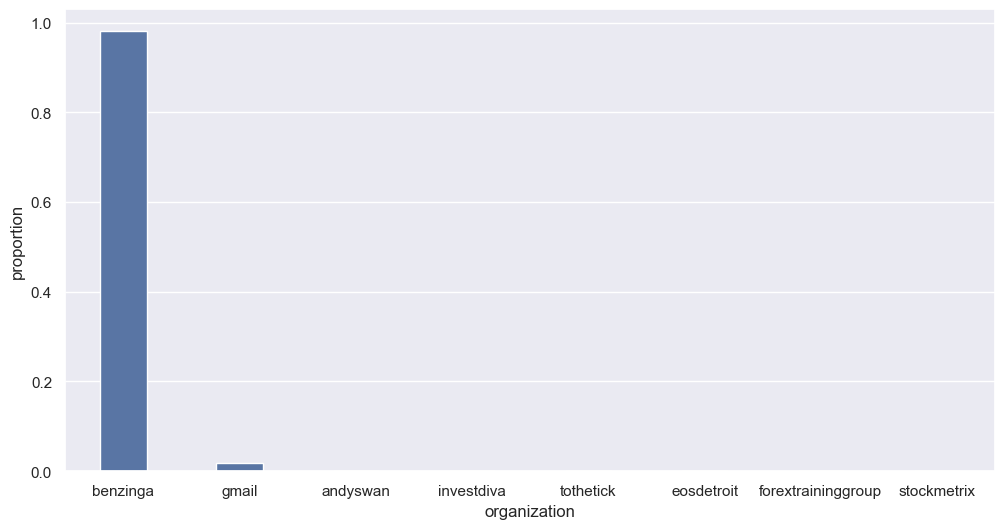

In [208]:
fig = plt.figure(figsize=(12,6))
sns.barplot(email_publishers["organization"].value_counts(normalize=True) , width=0.4)

We can see that from the **8,088** data points with emails as their publisher name:
* 7,937(98.13%) come from the company **benziga**
* 139(1.7%) come from **gmail** which means the publishers used personal email and don't represent a company
* 5 come from **andyswan**
* 4 come **investdive** and **tothetick**, both having 2
* 3 come from **eosdetroit**, **forextraininggroup** and **stockmetrix**: each having 1
 

On previous cells , Descriptive statistics part to be exact , we have seen the top 50 publishers. Now let us look at the type of news they publish, the sentiment of the news

In [209]:
grouping = news_df.groupby(['publisher', 'sentiment_category'])
sentiment_counts = grouping.size().unstack(fill_value=0).reset_index()

C:\Users\VICTUS 16\AppData\Local\Temp\ipykernel_14048\2213367105.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouping = news_df.groupby(['publisher', 'sentiment_category'])


* Let us see the top 20 publisher with a headline that has a very-negative sentiment

In [210]:
sentiment_counts.sort_values(by='very-negative' , ascending=False).head(20)

sentiment_category,publisher,very-negative,negative,neutral,positive,very-positive
96,Benzinga Newsdesk,1883,35795,62776,42343,7687
686,Paul Quintaro,989,23538,133566,64718,5562
169,Charles Gross,676,11455,42990,39711,1900
478,Juan Lopez,348,7396,15156,5470,68
777,Shanthi Rexaline,303,3494,7663,4781,399
112,Benzinga Newsdesk,297,293,25,706,2259
275,Eddie Staley,226,6874,31856,16807,1491
418,Jayson Derrick,211,3689,8539,6071,540
449,Joe Young,190,2149,5928,2431,79
353,Hal Lindon,187,4382,28597,14578,1303


* Let us see the top 20 publisher with a headline that has a very-positive sentiment

In [211]:
sentiment_counts.sort_values(by='very-positive' , ascending=False).head(20)

sentiment_category,publisher,very-negative,negative,neutral,positive,very-positive
96,Benzinga Newsdesk,1883,35795,62776,42343,7687
686,Paul Quintaro,989,23538,133566,64718,5562
112,Benzinga Newsdesk,297,293,25,706,2259
169,Charles Gross,676,11455,42990,39711,1900
275,Eddie Staley,226,6874,31856,16807,1491
353,Hal Lindon,187,4382,28597,14578,1303
532,Lisa Levin,187,30919,108868,45743,1262
111,Benzinga_Newsdesk,110,4300,8823,5363,814
98,Benzinga Staff,68,2174,17715,7588,569
622,Monica Gerson,83,10234,41393,30124,546


* Let us see the top 20 publisher with a headline that has a positive sentiment

In [212]:
sentiment_counts.sort_values(by='positive' , ascending=False).head(20)

sentiment_category,publisher,very-negative,negative,neutral,positive,very-positive
686,Paul Quintaro,989,23538,133566,64718,5562
532,Lisa Levin,187,30919,108868,45743,1262
96,Benzinga Newsdesk,1883,35795,62776,42343,7687
169,Charles Gross,676,11455,42990,39711,1900
622,Monica Gerson,83,10234,41393,30124,546
275,Eddie Staley,226,6874,31856,16807,1491
353,Hal Lindon,187,4382,28597,14578,1303
98,Benzinga Staff,68,2174,17715,7588,569
208,Craig Jones,20,851,8365,6905,80
418,Jayson Derrick,211,3689,8539,6071,540


* Let us see the top 20 publisher with a headline that has a negative sentiment

In [213]:
sentiment_counts.sort_values(by='negative' , ascending=False).head(20)

sentiment_category,publisher,very-negative,negative,neutral,positive,very-positive
96,Benzinga Newsdesk,1883,35795,62776,42343,7687
532,Lisa Levin,187,30919,108868,45743,1262
686,Paul Quintaro,989,23538,133566,64718,5562
169,Charles Gross,676,11455,42990,39711,1900
622,Monica Gerson,83,10234,41393,30124,546
907,Vick Meyer,0,8256,11107,5407,56
478,Juan Lopez,348,7396,15156,5470,68
275,Eddie Staley,226,6874,31856,16807,1491
353,Hal Lindon,187,4382,28597,14578,1303
111,Benzinga_Newsdesk,110,4300,8823,5363,814


* Let us see the top 20 publisher with a headline that has a neutral sentiment

In [214]:
sentiment_counts.sort_values(by='neutral' , ascending=False).head(20)

sentiment_category,publisher,very-negative,negative,neutral,positive,very-positive
686,Paul Quintaro,989,23538,133566,64718,5562
532,Lisa Levin,187,30919,108868,45743,1262
96,Benzinga Newsdesk,1883,35795,62776,42343,7687
169,Charles Gross,676,11455,42990,39711,1900
622,Monica Gerson,83,10234,41393,30124,546
275,Eddie Staley,226,6874,31856,16807,1491
353,Hal Lindon,187,4382,28597,14578,1303
270,ETF Professor,101,2997,19064,6005,322
98,Benzinga Staff,68,2174,17715,7588,569
478,Juan Lopez,348,7396,15156,5470,68
